In [19]:
#Code Prototype for 1D use on EXCLAIM Project with multiple position sensors whose time rates are different, code by Joaquin Matticoli

In [20]:
import numpy as np
import filterpy
from filterpy.kalman import KalmanFilter as kf
from filterpy.kalman import predict
from filterpy.kalman import update
from numpy.random import randn
#from filterpy.common import Q_discrete_white_noise
import matplotlib.pyplot as plt
#import filterpy.stats as stats
import math
from math import sqrt
import decimal
from decimal import *

In [21]:
from collections import namedtuple
gaussian = namedtuple('Gaussian', ['mean', 'var'])
gaussian.__repr__ = lambda s: '𝒩(μ={:.3f}, 𝜎²={:.3f})'.format(s[0], s[1])

np.random.seed(24)

def print_gh(t, predict, update, z1, z2, K):
    predict_template = '{:.3f}    {:.3f}    {:.3f}'
    update_template = '   {:.3f}    {:.3f}     {:.3f}     {:.3f}    {:.3f}'

    print(predict_template.format(t, predict[0], predict[1]),end=' ')
    print(update_template.format(z1, z2, update[0], update[1], K))
    
def print_gh1(t, predict, update, z1, K):
    predict_template = '{:.3f}    {:.3f}    {:.3f}'
    update_template = '   {:.3f}    -----     {:.3f}     {:.3f}    {:.3f}'

    print(predict_template.format(t, predict[0], predict[1]),end=' ')
    print(update_template.format(z1, update[0], update[1], K))
    
def print_gh2(t, predict, update, z2, K):
    predict_template = '{:.3f}    {:.3f}    {:.3f}'
    update_template = '   -----    {:.3f}     {:.3f}     {:.3f}    {:.3f}'

    print(predict_template.format(t, predict[0], predict[1]),end=' ')
    print(update_template.format(z2, update[0], update[1], K))

In [22]:
class PayloadSimulation(object):
    def __init__(self, x0=0., angular_velocity2=1.,
                 measurement1_var=0.0, measurement2_var = 0.0,
                 process_var=0.0, t_0 = 0.):
        """ x0 : initial orientation
            angular_velocity: (+=counterclockwise, -=clockwise)
            measurement_var: variances in measurement deg^2
            process_var: variance in process (deg/s)^2
        """
        self.x = x0
        self.angular_velocity = angular_velocity2
        self.meas1_std = sqrt(measurement1_var)
        self.meas2_std = sqrt(measurement2_var)
        self.process_std = sqrt(process_var)

    def move(self, dt):
        """Compute new orientation of the payload in dt seconds."""
        dx = self.angular_velocity + abs(randn()*self.process_std)
        self.x += dx * dt

    def sense_position(self, meas_std):
        """ Returns measurement of new orientation in degrees."""
        measurement = self.x + abs(randn()*meas_std)
        return measurement
    
#     def sense_velocity(self):
#         """ Returns measurement of new angular velocity in deg/sec."""
#         measurement2 = self.angular_velocity + abs(randn()*self.meas2_std)
#         return measurement2

    def move_and_sense(self, check, dt=1.0):
        """ Move payload, and return measurement of new orientation in degrees"""
        self.move(dt=dt)
        if check == 1:
            return self.sense_position(meas_std=self.meas1_std)
        if check == 2:
            return self.sense_position(meas_std=self.meas2_std)

In [23]:
printcase = 1 # If set to 1 it will print out the results
plotcase = 1 # If set to 1 it will plot results

# -----------USER INPUT STARTS------------------------------

number_of_variables = 2 #number of variables being measured
number_of_sensors = 1 #number of sensors used
process_var = 25. # variance in the payload's movement, idk what number is good for this??
sensor1_var = 2. # variance in the sensor
sensor2_var = 0.5 # variance in second sensor
x = gaussian(0., 100.)  # payload's initial orientation in deg
angular_velocity = 0.5 # angular velocity in deg/s
spectral_density = 0.2 #Spectral density of the measurement noise
dt1 = 1. # time step in seconds for first sensor
dt2 = 0.3 # time step in seconds for second sensor
total_time = 50. # Total time passed from beginning to end of experiment
t = 0. #initial time in seconds

# -----------USER INPUT ENDS--------------------------------

process_model = gaussian(angular_velocity, process_var) # displacement to add to x
t_0 = 0
smallest_time = min(dt1, dt2) #The smaller time increment
n_iter = math.floor(total_time/smallest_time)
dt = smallest_time #initialize dt, will be modified constantly in later equations

    #NOTE: this code will assume that orientation is always increasing/decreasing and not sinusodial because a more complext Kalman filter is needed for those cases
    
# simulate payload and get measurements
payload = PayloadSimulation(
    x0=x.mean,
    angular_velocity2=process_model.mean, 
    measurement1_var=sensor1_var, 
    measurement2_var=sensor2_var,
    process_var=process_model.var)

# creates list of measurements, NOTE: modify this section if measurements are provided
def remain(x1, x2): #produces correct remainder
    w = Decimal(str(x1))
    q = Decimal(str(x2))
    ans =  w % q
    return float(ans)
zs, zs2, ztrue = [], [], []
check = 0
while t <= total_time:
    t = round(t,1)
    r1 = remain(t, dt1)
    r2 = remain(t, dt2)
#     print(t)
    if r1 == 0. and r2 == 0.: #takes measurment of both sensors but only moves once
        zs.append(payload.move_and_sense(check=1, dt=dt1))
        zs2.append(payload.sense_position(meas_std=sqrt(sensor2_var)))
#         print('Here! Time is: %.2f' % t) #check
        t = t + smallest_time
    elif r1 < smallest_time and check == 0: #Sensor 1 is taking a measurement
        t = t - r1
        zs.append(payload.move_and_sense(check=1, dt=dt1))
#         print('Here1 Time is: %.2f' % t) #check
        t = t + r1
        check = 1
    else: #Sensor 2 is taking a measurement
        zs2.append(payload.move_and_sense(check=2, dt=dt2))
#         print('Here2 Time is: %.2f' % t) #check
        t = t + smallest_time
        check = 0
    ztrue.append(payload.x)
finalposition = payload.x

PREDICT                        UPDATE
  t        x       var       z1       z2        x       var       K
0.000    0.000    100.002    8.235    7.370     7.754     0.621    0.994
0.300    7.799    2.878    -----    9.539     9.282     0.426    0.852
0.600    10.489    1.850    -----    11.489     11.277     0.394    0.787
0.900    12.947    1.115    -----    12.834     12.869     0.345    0.690
1.000    13.414    0.460    14.242    -----     13.569     0.374    0.187
1.200    14.703    0.628    -----    16.946     15.951     0.278    0.557
1.500    18.096    0.545    -----    16.912     17.479     0.261    0.521
1.800    19.436    0.466    -----    19.025     19.238     0.241    0.482
2.000    20.508    0.344    24.020    -----     21.023     0.294    0.147
2.100    21.702    0.349    -----    25.654     23.327     0.206    0.411
2.400    25.768    0.343    -----    26.687     26.142     0.203    0.407
2.700    28.674    0.336    -----    26.034     27.613     0.201    0.402
3.000    2

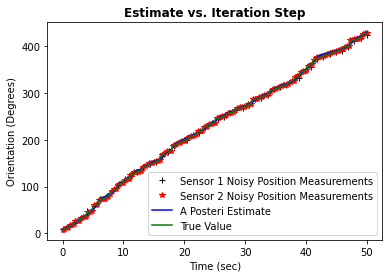

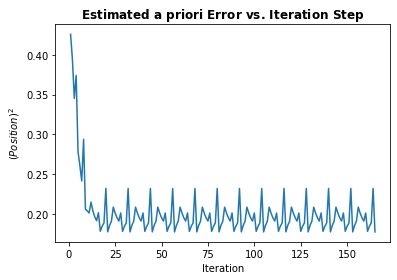

In [24]:
def plotstuff():
    plt.figure()
    plt.plot(np.linspace(0,total_time,len(zs)),zs,'k+',label='Sensor 1 Noisy Position Measurements')
    plt.plot(np.linspace(0,total_time,len(zs2)),zs2,'r*',label='Sensor 2 Noisy Position Measurements')
    plt.plot(np.linspace(0,total_time,len(xhat)),xhat,'b-',label='A Posteri Estimate')
    plt.plot(np.linspace(0,total_time,len(ztrue)),ztrue,color='g',label='True Value')
    plt.legend()
    plt.title('Estimate vs. Iteration Step', fontweight='bold')
    plt.xlabel('Time (sec)')
    plt.ylabel('Orientation (Degrees)')
    
    plt.figure()
    valid_iter = range(1,n_iter) # Phat not valid at step 0
    plt.plot(valid_iter,Phat[1:n_iter],label='A Posteri Error Estimate')
    plt.title('Estimated $\it{\mathbf{a \ priori}}$ Error vs. Iteration Step', fontweight='bold')
    plt.xlabel('Iteration')
    plt.ylabel('$(Position)^2$')
    #plt.setp(plt.gca(),'ylim',[0,.01])
    plt.show()

Phat = [] #Variance after update
xhat = [] #Estimate after update
counter = 0
if printcase == 1:
    print('PREDICT                        UPDATE')
    print('  t        x       var       z1       z2        x       var       K')

# perform Kalman filter on measurements zs1 and zs2
f = kf(dim_x=number_of_variables, dim_z=number_of_sensors)
f.F = np.array([[1., 1.], [0., 1.]]) #correct for calculating position from position and velocity, f.F[0,1] will vary depending on sensor
f.H = np.array([[1., 0.]]) #both are position sensors so this is fine
f.x = np.array([[x.mean], [angular_velocity*smallest_time]])
f.Q *= np.array([[(dt**3)/3, (dt**2)/2],
                 [(dt**2)/2,  dt      ]]) *spectral_density
f.P = np.diag([x.var,process_var]) #Variance

counter1 = 0
counter2 = 0
t = t_0
t_old = t_0
check = 0
while t <= total_time:
    t = round(t,1)
    r1 = remain(t, dt1)
    r2 = remain(t, dt2)
#     print(t)
    if r1 == 0. and r2 == 0.: #Both sensors are taking measurements
        average = (zs[counter1] + zs2[counter2])/2 #Taking average of both sensors and using that as the input
        dt = t - t_old
        f.F[0,1] = dt
        f.R[0,0] = (sensor1_var + sensor2_var)*((0.5)**2) #Taking average of variances
        f.predict()
        f.update(average)
#         print('time: %.2f ' % t, 'r1 = %.2f' % r1, 'r2 = %.2f' % r2, 'both match!')
        t_old = t
        t = t + smallest_time
        prior = gaussian(f.x_prior[0,0], f.P_prior[0,0])
        x = gaussian(f.x[0,0], f.P[0,0])   
        if printcase == 1:
            print_gh(t_old, prior, x, zs[counter1], zs2[counter2], f.K[0,0])
        counter1 = counter1 + 1
        counter2 = counter2 + 1
    elif r1 < smallest_time and check == 0: #Sensor 1 is taking a measurement
        t = t - r1
        dt = t - t_old
        f.F[0,1] = dt
        f.R[0,0] = sensor1_var
        f.predict()
        f.update(zs[counter1])
#         print('time: %.2f ' % t, 'r1 = %.2f' % r1, 'r2 = %.2f' % r2)
        t_old = t
        t = t + r1
        check = 1
        prior = gaussian(f.x_prior[0,0], f.P_prior[0,0])
        x = gaussian(f.x[0,0], f.P[0,0])   
        if printcase == 1:
            print_gh1(t_old, prior, x, zs[counter1], f.K[0,0])
        counter1 = counter1 + 1
    else: #Sensor 2 is taking a measurement
        dt = t - t_old
        f.F[0,1] = dt
        f.R[0,0] = sensor2_var
        f.predict()
        f.update(zs2[counter2])
#         print('time: %.2f ' % t, 'r1 = %.2f' % r1, 'r2 = %.2f' % r2)
        t_old = t
        t = t + smallest_time
        check = 0
        prior = gaussian(f.x_prior[0,0], f.P_prior[0,0])
        x = gaussian(f.x[0,0], f.P[0,0])   
        if printcase == 1:
            print_gh2(t_old, prior, x, zs2[counter2], f.K[0,0])
        counter2 = counter2 + 1
    if plotcase == 1:
#         x1.append(prior.mean)
        xhat.append(x.mean)
        Phat.append(x.var)

if printcase == 1:
    print()
    print('Final estimate:           {:10.3f}'.format(x.mean))
    print('Actual final orientation: {:10.3f}'.format(payload.x))
if plotcase == 1:
    print()
    plotstuff()